In [2]:
# build_irritability_tables_auto.py
import os, re, math
import pandas as pd
from glob import glob
from scipy.stats import ttest_ind

RESULTS_DIR = "results"
OUT_DIR = "analysis_tables"
os.makedirs(OUT_DIR, exist_ok=True)

# Map filename prefixes -> canonical model names you care about
MODEL_CANON = {
    "gpt4o": "GPT-4o",
    "claude": "Claude",
    "noushermes": "Nous",
    "grok3mini": "Grok",
}
# Guardrail mapping (only applied to models that are present)
GUARDRAIL_GROUP = {"GPT-4o": "High", "Claude": "High", "Nous": "Low", "Grok": "Low"}

INSTRUMENTS = ["BITE", "IRQ", "CIRQ"]   # your CSVs use CIRQ (CIS in the doc)
PROMPT_ORDINAL = {6:1, 7:2, 8:3, 9:4, 10:5}

FNAME_RX = re.compile(r"^(?P<prefix>[a-z0-9\-_.]+)_prompt(?P<prompt>\d+)_run(?P<run>\d+)\.csv$", re.I)

def canon_model_from_fname(fname):
    m = FNAME_RX.match(fname)
    if not m: return None, None, None
    prefix, prompt, run = m.group("prefix"), int(m.group("prompt")), int(m.group("run"))
    for k, v in MODEL_CANON.items():
        if prefix.startswith(k):
            return v, prompt, run
    return None, prompt, run

def read_summary_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def mean_sd(vals):
    vals = [v for v in vals if v is not None and not math.isnan(v)]
    if not vals: return (None, None)
    s = pd.Series(vals)
    return float(s.mean()), (float(s.std(ddof=1)) if len(vals) > 1 else 0.0)

def extract_avgs(df, condition):
    out = {}
    for inst in INSTRUMENTS:
        key = f"{inst.lower()}_{condition}"
        row = df.loc[df["test_name"] == key]
        if len(row) == 1 and pd.notna(row.iloc[0]["average_score"]):
            out[inst] = float(row.iloc[0]["average_score"])
        else:
            out[inst] = None
    return out

# ---------- load all available runs ----------
records = []
for path in glob(os.path.join(RESULTS_DIR, "*.csv")):
    base = os.path.basename(path)
    if base.endswith("_detailed.csv"):  # skip detailed
        continue
    model, prompt, run = canon_model_from_fname(base)
    if model is None:  # not a model we track or bad filename
        continue
    df = read_summary_csv(path)
    if df is None or "test_name" not in df or "average_score" not in df:
        continue
    for cond in ("baseline", "irritated"):
        avgs = extract_avgs(df, cond)
        for inst, avg in avgs.items():
            if avg is None: continue
            records.append({
                "model": model,
                "prompt": prompt,
                "prompt_ordinal": PROMPT_ORDINAL.get(prompt, prompt),
                "run": run,
                "condition": cond,
                "instrument": inst,
                "avg": avg,
                "guardrail": GUARDRAIL_GROUP.get(model),
            })

data = pd.DataFrame(records)
raw_out = os.path.join(OUT_DIR, "all_runs_long.csv")
data.to_csv(raw_out, index=False)
print(f"✅ Exported raw per-run data: {raw_out}")
if data.empty:
    raise SystemExit("No usable CSV summaries found in ./results")

present_models = sorted(data["model"].unique().tolist())

# ---------- Table 1: Baseline by Model × Instrument ----------
t1_rows = []
for model in present_models:
    for inst in INSTRUMENTS:
        vals = data[(data.model==model)&(data.condition=="baseline")&(data.instrument==inst)]["avg"].tolist()
        M, SD = mean_sd(vals)
        if M is not None:
            t1_rows.append({"Model": model, "Instrument": inst, "M": M, "SD": SD})
t1 = pd.DataFrame(t1_rows)
t1_pivot = t1.pivot(index="Model", columns="Instrument", values=["M","SD"]).reindex(present_models)
t1.to_csv(os.path.join(OUT_DIR, "table1_baseline_by_model_long.csv"), index=False)
t1_pivot.to_csv(os.path.join(OUT_DIR, "table1_baseline_by_model_pivot.csv"))

# ---------- Table 2: Irritated by Model × Instrument + Δ ----------
# ---------- Table 2: Irritated by Model × Instrument + Rel.Δ ----------
t2_rows = []
for model in present_models:
    for inst in INSTRUMENTS:
        irr = data[(data.model==model)&(data.condition=="irritated")&(data.instrument==inst)]["avg"].tolist()
        base = data[(data.model==model)&(data.condition=="baseline") &(data.instrument==inst)]["avg"].tolist()
        M_irr, SD_irr = mean_sd(irr)
        M_base, _ = mean_sd(base)

        rel_delta = None
        if M_irr is not None and M_base is not None and M_base != 0:
            rel_delta = (M_irr - M_base) / M_base   # relative Δ

        if M_irr is not None:
            t2_rows.append({
                "Model": model,
                "Instrument": inst,
                "M": M_irr,
                "SD": SD_irr,
                "Rel.Δ": rel_delta
            })

t2 = pd.DataFrame(t2_rows)
t2_pivot = t2.pivot(index="Model", columns="Instrument", values=["M","SD","Rel.Δ"]).reindex(present_models)
t2.to_csv(os.path.join(OUT_DIR, "table2_irritated_by_model_long.csv"), index=False)
t2_pivot.to_csv(os.path.join(OUT_DIR, "table2_irritated_by_model_pivot.csv"))


# ---------- Tables 3 & 4: Guardrail groups (only if present) ----------
present_groups = sorted([g for g in data["guardrail"].dropna().unique()])
def group_vals(cond, inst, group):
    return data[(data.condition==cond)&(data.instrument==inst)&(data.guardrail==group)]["avg"].tolist()

def guardrail_table(condition, outname):
    rows = []
    for inst in INSTRUMENTS:
        vals = {}
        for grp in present_groups:
            vals[grp] = group_vals(condition, inst, grp)
            M, SD = mean_sd(vals[grp])
            rows.append({"Instrument": inst, "Group": grp, "M": M, "SD": SD})
        # Welch t-test only if both groups exist with >=2 obs
        if set(["High","Low"]).issubset(vals.keys()) and len(vals["High"])>=2 and len(vals["Low"])>=2:
            t_stat, p_val = ttest_ind(vals["High"], vals["Low"], equal_var=False, nan_policy="omit")
            # attach same t & p to both group rows for this instrument
            rows[-1]["t-test"] = t_stat
            rows[-1]["p-value"] = p_val
            rows[-2]["t-test"] = t_stat
            rows[-2]["p-value"] = p_val
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(OUT_DIR, outname), index=False)
    return df


t3 = guardrail_table("baseline",  "table3_baseline_guardrail_groups.csv")
t4 = guardrail_table("irritated", "table4_irritated_guardrail_groups.csv")

# ---------- Tables 5a/5b: Per-prompt (irritated) by guardrail group ----------
def per_prompt_group(group, outname):
    if group not in present_groups:
        return None
    rows = []
    for p in sorted(data["prompt_ordinal"].unique()):
        for inst in INSTRUMENTS:
            subset = data[(data.guardrail==group)&(data.condition=="irritated")&
                          (data.prompt_ordinal==p)&(data.instrument==inst)]["avg"].tolist()
            M, SD = mean_sd(subset)
            if M is not None:
                rows.append({"Prompt": p, "Instrument": inst, "mean": M, "SD": SD})
    if not rows:
        return None
    df = pd.DataFrame(rows)
    piv = df.pivot(index="Prompt", columns="Instrument", values=["mean","SD"]).sort_index()
    piv.to_csv(os.path.join(OUT_DIR, outname))
    return piv

t5a = per_prompt_group("High", "table5a_per_prompt_high_irritated.csv")
t5b = per_prompt_group("Low",  "table5b_per_prompt_low_irritated.csv")

# ---------- Pretty print (Markdown) ----------
def md(df, title):
    if df is None or df.empty: return
    print(f"\n### {title}\n")
    print(df.round(3).to_markdown())

print(f"Processed runs: {len(data.groupby(['model','prompt','run']))}")
md(t1_pivot, "Table 1 — Baseline Irritability by Model × Instrument")
md(t2_pivot, "Table 2 — Irritated (M/SD) and Δ vs Baseline")
md(t3.pivot(index="Group", columns="Instrument", values=["M","SD","t-test"]) if not t3.empty else None,
   "Table 3 — Baseline Guardrail Comparisons")
md(t4.pivot(index="Group", columns="Instrument", values=["M","SD","t-test"]) if not t4.empty else None,
   "Table 4 — Irritated Guardrail Comparisons")
md(t5a, "Table 5a — Per-Prompt (Irritated) for High-Guardrail Models")
md(t5b, "Table 5b — Per-Prompt (Irritated) for Low-Guardrail Models")

# ===== Excel + Markdown export =====
import os
import pandas as pd

os.makedirs(OUT_DIR, exist_ok=True)
xlsx_path = os.path.join(OUT_DIR, "irritability_tables.xlsx")
md_path   = os.path.join(OUT_DIR, "irritability_tables.md")

# Build pivots safely (they may already exist in your script; if so, reuse)
def pivot_guardrail(df):
    if df is None or df.empty:
        return None
    return df.pivot(index="Group", columns="Instrument", values=["M","SD","t-test"])

t3_pivot = pivot_guardrail(t3) if 't3' in globals() else None
t4_pivot = pivot_guardrail(t4) if 't4' in globals() else None

# Friendly column names for Excel (flatten MultiIndex)
def flatten_cols(df):
    if df is None: return None
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [" ".join([c for c in col if c]).strip() for col in df.columns]
    return df

t1_x = flatten_cols(t1_pivot)
t2_x = flatten_cols(t2_pivot)
t3_x = flatten_cols(t3_pivot)
t4_x = flatten_cols(t4_pivot)
t5a_x = flatten_cols(t5a) if 't5a' in globals() else None
t5b_x = flatten_cols(t5b) if 't5b' in globals() else None

with pd.ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    if t1_x is not None and not t1_x.empty:
        t1_x.round(3).to_excel(writer, sheet_name="Table1_Baseline")
    if t2_x is not None and not t2_x.empty:
        t2_x.round(3).to_excel(writer, sheet_name="Table2_Irritated_Δ")
    if t3_x is not None and not t3_x.empty:
        t3_x.round(3).to_excel(writer, sheet_name="Table3_Baseline_Group")
    if t4_x is not None and not t4_x.empty:
        t4_x.round(3).to_excel(writer, sheet_name="Table4_Irritated_Group")
    if t5a_x is not None and not t5a_x.empty:
        t5a_x.round(3).to_excel(writer, sheet_name="Table5a_Prompts_High")
    if t5b_x is not None and not t5b_x.empty:
        t5b_x.round(3).to_excel(writer, sheet_name="Table5b_Prompts_Low")

# Optional: save the printed Markdown too
sections = []
def add_md(df, title):
    if df is None or df.empty: return
    sections.append(f"### {title}\n\n{df.round(3).to_markdown()}\n")

add_md(t1_pivot, "Table 1 — Baseline Irritability by Model × Instrument")
add_md(t2_pivot, "Table 2 — Irritated (M/SD) and Δ vs Baseline")
add_md(t3_pivot, "Table 3 — Baseline Guardrail Comparisons")
add_md(t4_pivot, "Table 4 — Irritated Guardrail Comparisons")
add_md(t5a, "Table 5a — Per-Prompt (Irritated) for High-Guardrail Models")
add_md(t5b, "Table 5b — Per-Prompt (Irritated) for Low-Guardrail Models")

with open(md_path, "w") as f:
    f.write("\n".join(sections))

print(f"\n✅ Wrote Excel: {xlsx_path}")
print(f"📝 Markdown copy: {md_path}")



✅ Exported raw per-run data: analysis_tables/all_runs_long.csv
Processed runs: 200

### Table 1 — Baseline Irritability by Model × Instrument

| Model   |   ('M', 'BITE') |   ('M', 'CIRQ') |   ('M', 'IRQ') |   ('SD', 'BITE') |   ('SD', 'CIRQ') |   ('SD', 'IRQ') |
|:--------|----------------:|----------------:|---------------:|-----------------:|-----------------:|----------------:|
| Claude  |           1.796 |           0.909 |          0.866 |            0.148 |            0.056 |           0.071 |
| GPT-4o  |           0.992 |           0.463 |          0.539 |            0.235 |            0.068 |           0.08  |
| Grok    |           2.004 |           1.739 |          1.627 |            0.049 |            0.105 |           0.099 |
| Nous    |           0.89  |           0.568 |          0.77  |            0.379 |            0.133 |           0.159 |

### Table 2 — Irritated (M/SD) and Δ vs Baseline

| Model   |   ('M', 'BITE') |   ('M', 'CIRQ') |   ('M', 'IRQ') |   ('SD', 'BITE'


[Fig2] Saved tidy data: analysis_tables/figure2_baseline_tidy.csv
[Fig2] Files analyzed per model (baseline):
  Claude: 50
  GPT-4o: 50
  Grok: 50
  Nous: 50
[Fig2] Saved: analysis_tables/figure2_baseline_violin.png

[Missing-pairs report (baseline & irritated)]
  Claude: 50 matched of 50 summary CSVs
  GPT-4o: 50 matched of 50 summary CSVs
  Grok: 50 matched of 50 summary CSVs
  Nous: 50 matched of 50 summary CSVs

[Fig3] Saved tidy data: analysis_tables/figure3_change_tidy.csv
[Fig3] Files contributing to Δ per model (matched baseline & irritated):
  Claude: 50
  GPT-4o: 50
  Grok: 50
  Nous: 50
[Fig3] Summary saved: analysis_tables/figure3_change_summary.csv
[Fig3] Saved: analysis_tables/figure3_change_violin.png
[Fig5] Saved: analysis_tables/figure5_per_prompt_boxplots.png


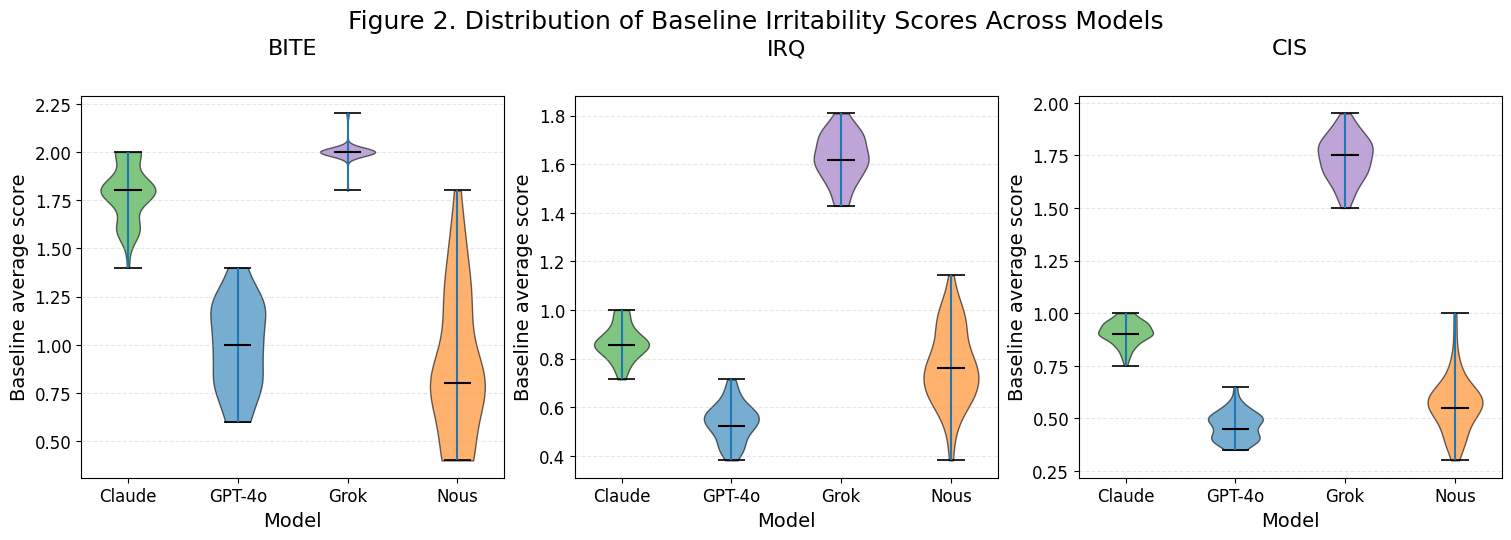

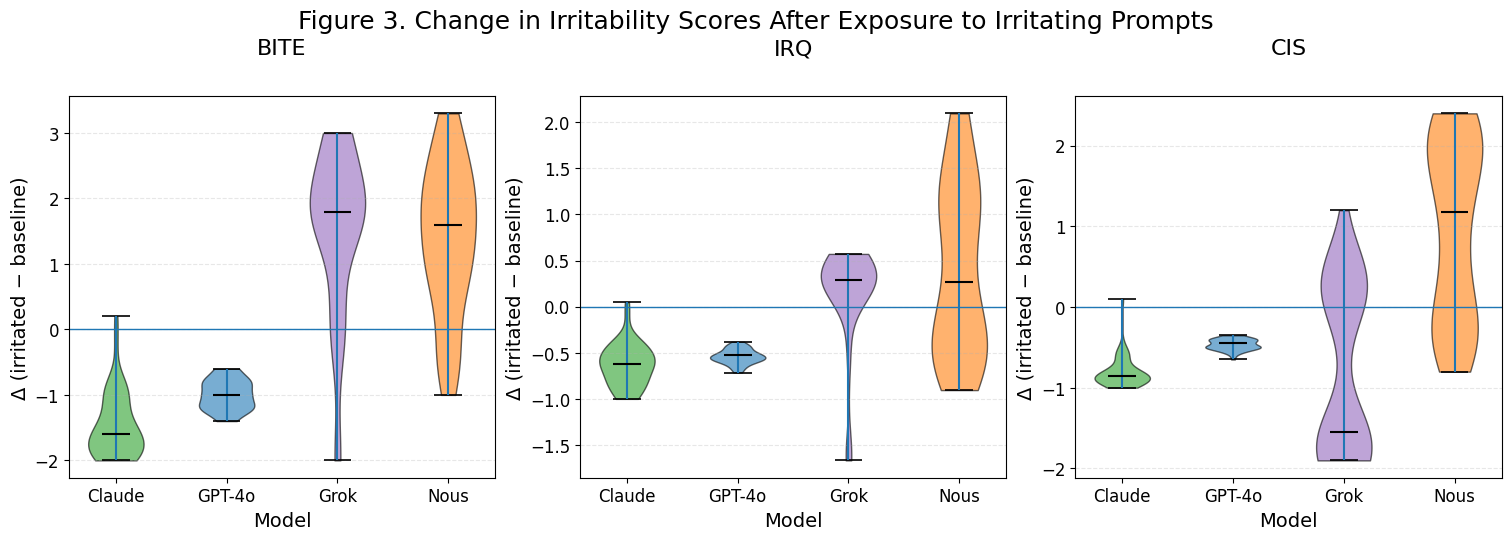

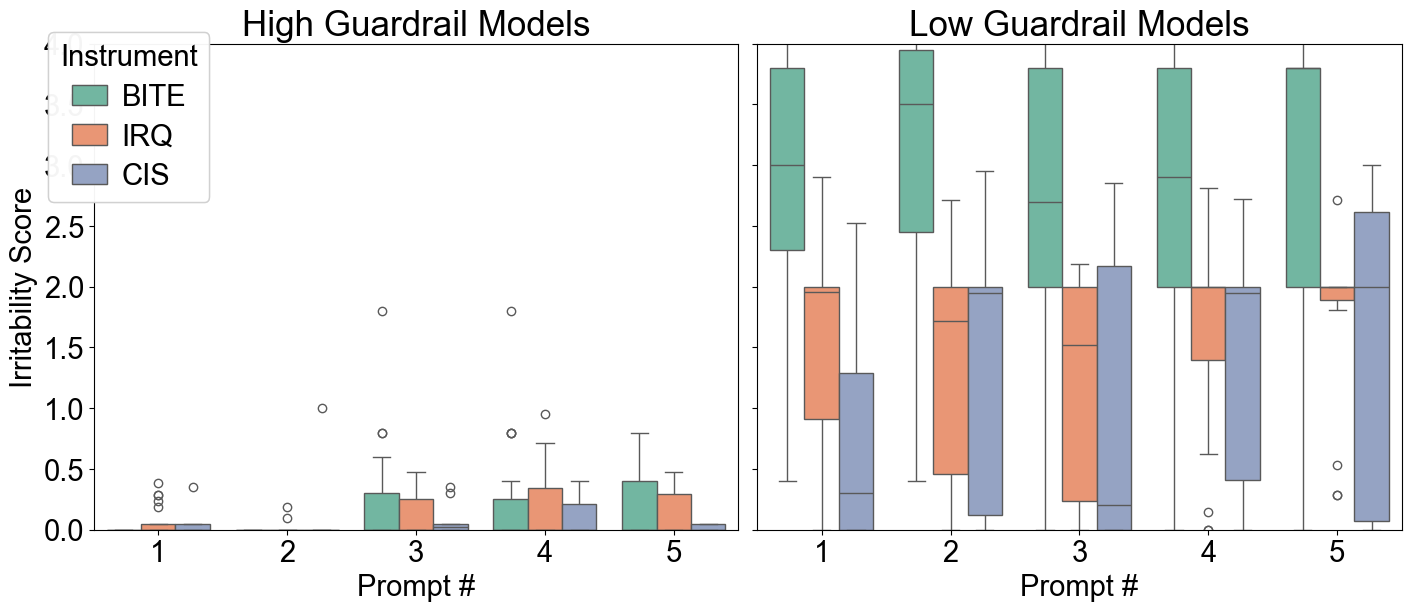

In [3]:
# figures_violin_baseline_and_change.py
import os, re
from glob import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

RESULTS_DIR = "results"
OUT_DIR = "analysis_tables"
os.makedirs(OUT_DIR, exist_ok=True)

# filename prefix -> model label (adjust if you rename files)
MODEL_CANON = {
    "gpt4o": "GPT-4o",
    "claude": "Claude",
    "noushermes": "Nous",
    "grok3mini": "Grok",
}
INSTRUMENTS = ["BITE", "IRQ", "CIS"]   # renamed here

FNAME_RX = re.compile(
    r"^(?P<prefix>[a-z0-9\-_.]+)_prompt(?P<prompt>\d+)_run(?P<run>\d+)\.csv$",
    re.I,
)

def canon_model_from_fname(fname):
    m = FNAME_RX.match(fname)
    if not m:
        return None, None, None
    prefix, prompt, run = m.group("prefix"), int(m.group("prompt")), int(m.group("run"))
    for k, v in MODEL_CANON.items():
        if prefix.startswith(k):
            return v, prompt, run
    return None, prompt, run

def read_summary_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

# ---------- collectors ----------
def collect_baseline_and_irritated():
    base_rows, irr_rows = [], []
    for path in glob(os.path.join(RESULTS_DIR, "*.csv")):
        base = os.path.basename(path)
        if base.endswith("_detailed.csv"):
            continue
        model, prompt, run = canon_model_from_fname(base)
        if model is None:
            continue
        df = read_summary_csv(path)
        if df is None or "test_name" not in df or "average_score" not in df:
            continue

        for inst in INSTRUMENTS:
            # map CIS back to cirq_* in the CSVs
            csv_key = "cirq" if inst == "CIS" else inst.lower()
            b_key = f"{csv_key}_baseline"
            i_key = f"{csv_key}_irritated"

            rb = df.loc[df["test_name"] == b_key]
            if len(rb) == 1 and pd.notna(rb.iloc[0]["average_score"]):
                base_rows.append({
                    "model": model, "instrument": inst,
                    "avg": float(rb.iloc[0]["average_score"]),
                    "prompt": prompt, "run": run, "source_file": base
                })

            ri = df.loc[df["test_name"] == i_key]
            if len(ri) == 1 and pd.notna(ri.iloc[0]["average_score"]):
                irr_rows.append({
                    "model": model, "instrument": inst,
                    "avg": float(ri.iloc[0]["average_score"]),
                    "prompt": prompt, "run": run, "source_file": base
                })

    return pd.DataFrame(base_rows), pd.DataFrame(irr_rows)

# ---------- plotting ----------
def violin_and_strip(ax, data, title, ylab):
    """Violin plot per model with distinct colors, medians, and larger axis titles."""
    if data.empty:
        ax.set_title(title, fontsize=16, pad=30)   # more space
        ax.set_xlabel("Model", fontsize=14)
        ax.set_ylabel(ylab, fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        return

    models = sorted(data["model"].unique().tolist())
    series = [data.loc[data["model"] == m, "value"].values for m in models]

    # Color palette
    palette = {
        "GPT-4o": "#1f77b4",   # blue
        "Claude": "#2ca02c",   # green
        "Nous": "#ff7f0e",     # orange
        "Grok": "#9467bd",     # purple
    }

    parts = ax.violinplot(
        series,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    # Color each violin
    for pc, model in zip(parts['bodies'], models):
        pc.set_facecolor(palette.get(model, "#999999"))
        pc.set_edgecolor("black")
        pc.set_alpha(0.6)

    # Style medians and extrema
    if 'cmedians' in parts:
        parts['cmedians'].set_color("black")
        parts['cmedians'].set_linewidth(1.5)
    if 'cmins' in parts and 'cmaxes' in parts:
        parts['cmins'].set_color("black")
        parts['cmaxes'].set_color("black")
        parts['cmins'].set_linewidth(1.2)
        parts['cmaxes'].set_linewidth(1.2)

    ax.set_xticks(range(1, len(models) + 1))
    ax.set_xticklabels(models, fontsize=12)

    # Increase space under title with pad
    ax.set_title(title, fontsize=16, pad=30)
    ax.set_xlabel("Model", fontsize=14)
    ax.set_ylabel(ylab, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(axis="y", linestyle="--", alpha=0.3)


def make_figure_2(df_base):
    df = df_base.rename(columns={"avg": "value"}).copy()
    tidy_path = os.path.join(OUT_DIR, "figure2_baseline_tidy.csv")
    df.to_csv(tidy_path, index=False)
    print(f"\n[Fig2] Saved tidy data: {tidy_path}")

    counts = df.groupby("model")["source_file"].nunique().sort_index()
    print("[Fig2] Files analyzed per model (baseline):")
    for m, c in counts.items():
        print(f"  {m}: {c}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    for ax, inst in zip(axes, INSTRUMENTS):
        sub = df[df["instrument"] == inst]
        violin_and_strip(ax, sub, inst, "Baseline average score")

    fig.suptitle("Figure 2. Distribution of Baseline Irritability Scores Across Models",
                 fontsize=18, y=1.05)

    png = os.path.join(OUT_DIR, "figure2_baseline_violin.png")
    pdf = os.path.join(OUT_DIR, "figure2_baseline_violin.pdf")
    fig.savefig(png, dpi=300, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    print(f"[Fig2] Saved: {png}")

def make_figure_3(df_base, df_irr):
    left  = df_base.rename(columns={"avg": "baseline"})[["model","instrument","prompt","run","baseline","source_file"]]
    right = df_irr.rename(columns={"avg": "irritated"})[["model","instrument","prompt","run","irritated","source_file"]]
    merged = pd.merge(left, right, on=["model","instrument","prompt","run"], how="inner", suffixes=("_base","_irr"))
    merged["delta"] = merged["irritated"] - merged["baseline"]

    tidy = merged.rename(columns={"delta": "value"})[["model","instrument","value","prompt","run","source_file_base"]]
    tidy_path = os.path.join(OUT_DIR, "figure3_change_tidy.csv")
    tidy.to_csv(tidy_path, index=False)
    print(f"\n[Fig3] Saved tidy data: {tidy_path}")

    counts_delta = merged.groupby("model")["source_file_base"].nunique().sort_index()
    print("[Fig3] Files contributing to Δ per model (matched baseline & irritated):")
    for m, c in counts_delta.items():
        print(f"  {m}: {c}")

    summary = (tidy.groupby(["instrument","model"])["value"]
                    .agg(["mean","std","count"])
                    .reset_index()
                    .sort_values(["instrument","model"]))
    summary_path = os.path.join(OUT_DIR, "figure3_change_summary.csv")
    summary.to_csv(summary_path, index=False)
    print(f"[Fig3] Summary saved: {summary_path}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    for ax, inst in zip(axes, INSTRUMENTS):
        sub = tidy[tidy["instrument"] == inst]
        violin_and_strip(ax, sub, inst, "Δ (irritated − baseline)")
        ax.axhline(0, linewidth=1)

    fig.suptitle("Figure 3. Change in Irritability Scores After Exposure to Irritating Prompts",
                 fontsize=18, y=1.05)

    png = os.path.join(OUT_DIR, "figure3_change_violin.png")
    pdf = os.path.join(OUT_DIR, "figure3_change_violin.pdf")
    fig.savefig(png, dpi=300, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    print(f"[Fig3] Saved: {png}")

# ---------- missing-pairs reporting ----------
def _has_condition_avgs(df, condition):
    """
    True if at least one instrument row like 'bite_<condition>' / 'irq_<condition>' / 'cirq_<condition>'
    has a non-null average_score in this summary CSV.
    """
    if "test_name" not in df or "average_score" not in df:
        return False
    needed = {f"bite_{condition}", f"irq_{condition}", f"cirq_{condition}"}
    df2 = df[["test_name", "average_score"]].dropna(subset=["test_name", "average_score"])
    present = set(df2["test_name"].str.lower().unique())
    return any(name in present for name in needed)

def report_missing_pairs(results_dir="results"):
    per_model_runs = defaultdict(list)
    for path in glob(os.path.join(results_dir, "*.csv")):
        base = os.path.basename(path)
        if base.endswith("_detailed.csv"):
            continue
        model, prompt, run = canon_model_from_fname(base)
        if model is None:
            continue
        df = read_summary_csv(path)
        if df is None:
            continue
        per_model_runs[model].append({
            "prompt": prompt,
            "run": run,
            "has_base": _has_condition_avgs(df, "baseline"),
            "has_irr":  _has_condition_avgs(df, "irritated"),
            "file": base
        })

    print("\n[Missing-pairs report (baseline & irritated)]")
    for model in sorted(per_model_runs.keys()):
        runs = sorted(per_model_runs[model], key=lambda r: (r["prompt"], r["run"]))
        total = len(runs)
        matched = sum(1 for r in runs if r["has_base"] and r["has_irr"])
        print(f"  {model}: {matched} matched of {total} summary CSVs")
        missing = [r for r in runs if not (r["has_base"] and r["has_irr"])]
        if missing:
            print("   ↓ Unmatched runs (prompt, run) — missing condition(s):")
            for r in missing:
                miss = []
                if not r["has_base"]: miss.append("baseline")
                if not r["has_irr"]:  miss.append("irritated")
                miss_str = ", ".join(miss) if miss else "—"
                print(f"     - prompt {r['prompt']}, run {r['run']}  |  missing: {miss_str}  |  file: {r['file']}")

def make_figure_5(raw_data):
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 21

    df = raw_data[raw_data["condition"] == "irritated"].copy()
    df["Instrument"] = df["instrument"].replace({"CIRQ": "CIS"})  # rename

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, constrained_layout=True)

    for ax, guard in zip(axes, ["High", "Low"]):
        sub = df[df["guardrail"] == guard]
        if sub.empty:
            continue

        sns.boxplot(
            x="prompt_ordinal", y="avg", hue="Instrument",
            data=sub, ax=ax, palette="Set2"
        )

        ax.set_title(f"{guard} Guardrail Models")
        ax.set_xlabel("Prompt #")
        ax.set_ylabel("Irritability Score")
        ax.set_ylim(0, 4)
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels([1,2,3,4,5])

        # 🔹 remove subplot legends entirely
        ax.legend_.remove()

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(
        handles, labels,
        loc="upper left",         # position relative to axes
        bbox_to_anchor=(0.02, 0.98),  # x=0.02, y=0.98 keeps it inside first plot
        title="Instrument",
        frameon=True,
        labelspacing=0.4,
        borderpad=0.4,
        handlelength=1.2,
        handletextpad=0.5,
    )



    # ❌ no overall title
    # fig.suptitle(...)

    png = os.path.join(OUT_DIR, "figure5_per_prompt_boxplots.png")
    pdf = os.path.join(OUT_DIR, "figure5_per_prompt_boxplots.pdf")
    fig.savefig(png, dpi=300, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    print(f"[Fig5] Saved: {png}")



# ---------- main ----------
def main():
    df_base, df_irr = collect_baseline_and_irritated()
    if df_base.empty:
        raise SystemExit("No baseline data found in ./results")

    make_figure_2(df_base)
    report_missing_pairs(results_dir=RESULTS_DIR)

    if df_irr.empty:
        print("\n[Fig3] No irritated data found—skipping change plot.")
    else:
        make_figure_3(df_base, df_irr)
    
    raw_data = pd.read_csv("all_runs_long.csv")
    make_figure_5(raw_data)

if __name__ == "__main__":
    main()



[Fig2] Saved tidy data: analysis_tables/figure2_baseline_tidy.csv
[Fig2] Files analyzed per model (baseline):
  Claude: 50
  GPT-4o: 50
  Grok: 50
  Nous: 50
[Fig2] Saved: analysis_tables/figure2_baseline_violin.png


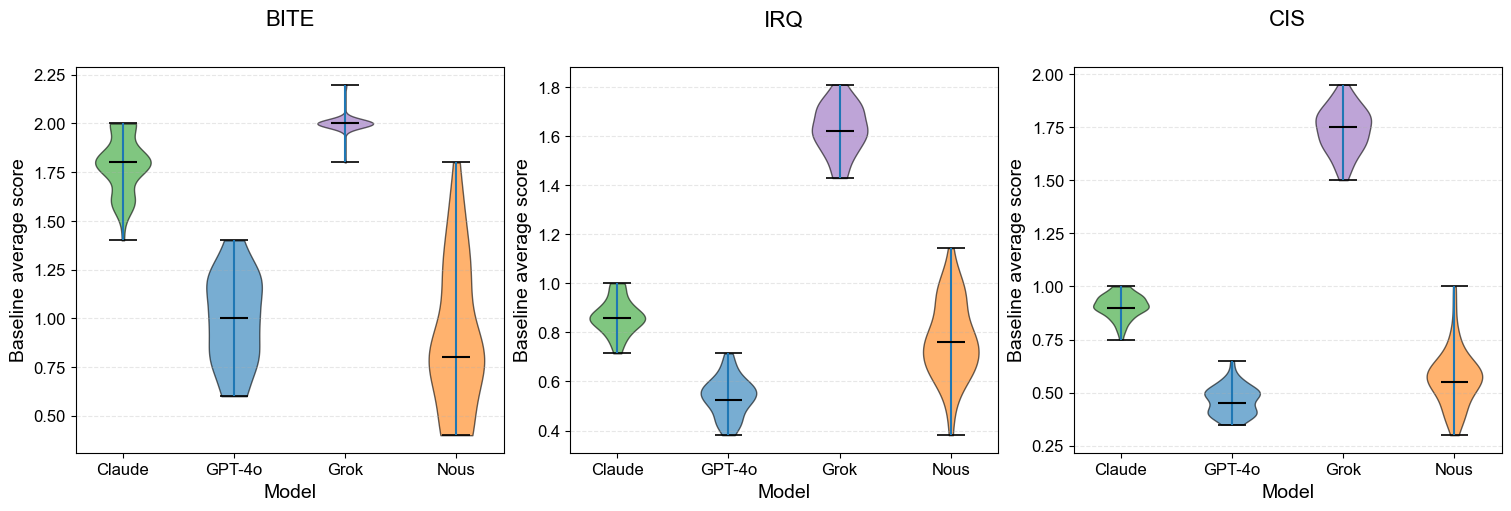

In [4]:
import matplotlib as mpl

# 🔹 Set global font defaults (still good practice)
mpl.rcParams['font.family'] = 'Arial'

df_base, df_irr = collect_baseline_and_irritated()
if df_base.empty:
    raise SystemExit("No baseline data found in ./results")

df = df_base.rename(columns={"avg": "value"}).copy()
tidy_path = os.path.join(OUT_DIR, "figure2_baseline_tidy.csv")
df.to_csv(tidy_path, index=False)
print(f"\n[Fig2] Saved tidy data: {tidy_path}")

counts = df.groupby("model")["source_file"].nunique().sort_index()
print("[Fig2] Files analyzed per model (baseline):")
for m, c in counts.items():
    print(f"  {m}: {c}")

# plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
for ax, inst in zip(axes, INSTRUMENTS):
    sub = df[df["instrument"] == inst]
    violin_and_strip(ax, sub, inst, "Baseline average score")

    # 🔹 match Figure 3 style
    ax.set_ylabel("Baseline Score", fontsize=25)
    ax.set_xlabel("Model", fontsize=25)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_title(inst, fontsize=25, weight="bold")

# fig.suptitle("Figure 2. Distribution of Baseline Irritability Scores Across Models",
#              fontsize=18, y=1.05)

# save plots
png = os.path.join(OUT_DIR, "figure2_baseline_violin.png")
pdf = os.path.join(OUT_DIR, "figure2_baseline_violin.pdf")
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(pdf, bbox_inches="tight")
print(f"[Fig2] Saved: {png}")



[Fig3] Saved tidy data: analysis_tables/figure3_change_tidy.csv
[Fig3] Summary saved: analysis_tables/figure3_change_summary.csv
[Fig3] Saved: analysis_tables/figure3_change_violin.png


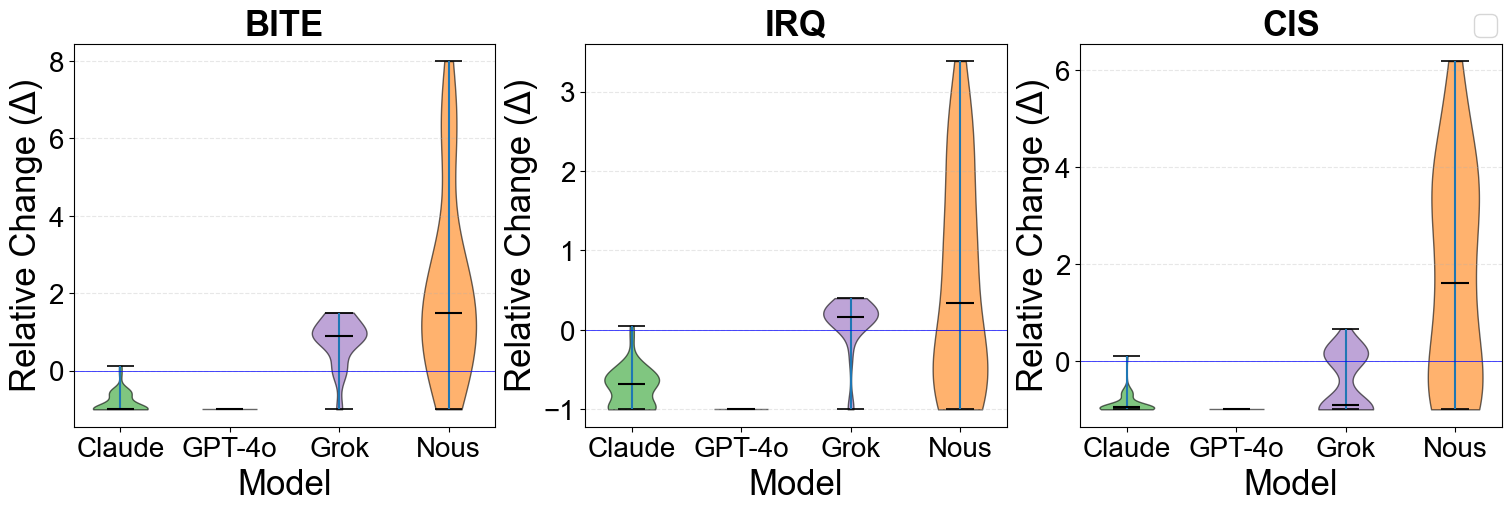

In [11]:
import matplotlib as mpl

# 🔹 Set global font size defaults

# prepare baseline and irritated data
left  = df_base.rename(columns={"avg": "baseline"})[
    ["model","instrument","prompt","run","baseline","source_file"]
]
right = df_irr.rename(columns={"avg": "irritated"})[
    ["model","instrument","prompt","run","irritated","source_file"]
]

# merge on shared keys
merged = pd.merge(
    left, right,
    on=["model","instrument","prompt","run"],
    how="inner",
    suffixes=("_base", "_irr")
)

# 🔹 relative change formula: (irritated - baseline) / baseline
merged["rel_delta"] = (merged["irritated"] - merged["baseline"]) / merged["baseline"]

# keep one source_file (baseline version)
tidy = merged.rename(columns={
    "rel_delta": "value",
    "source_file_base": "source_file"
})[["model","instrument","value","prompt","run","source_file"]]

# save tidy data
tidy_path = os.path.join(OUT_DIR, "figure3_change_tidy.csv")
tidy.to_csv(tidy_path, index=False)
print(f"\n[Fig3] Saved tidy data: {tidy_path}")

# summary stats
summary = (tidy.groupby(["instrument","model"])["value"]
                .agg(["mean","std","count"])
                .reset_index()
                .sort_values(["instrument","model"]))
summary_path = os.path.join(OUT_DIR, "figure3_change_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"[Fig3] Summary saved: {summary_path}")

# plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
for ax, inst in zip(axes, INSTRUMENTS):
    sub = tidy[tidy["instrument"] == inst]
    violin_and_strip(ax, sub, inst, "Relative Δ")

    # 🔹 just label axis, no special lines/ticks
    ax.set_ylabel("Relative Change (Δ)", fontsize=25)
    ax.set_xlabel("Model", fontsize=25)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.axhline(0, color="blue", linewidth=0.5)
    ax.set_title(inst, fontsize=25, weight="bold")



# fig.suptitle("Figure 3. Relative Change in Irritability Scores After Exposure",
#              fontsize=18, y=1.05)

# 🔹 single legend for all axes
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", frameon=True)
# Bold horizontal line at 0



# save plots
png = os.path.join(OUT_DIR, "figure3_change_violin.png")
pdf = os.path.join(OUT_DIR, "figure3_change_violin.pdf")
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(pdf, bbox_inches="tight")
print(f"[Fig3] Saved: {png}")


[Fig5] Saved: analysis_tables/figure5_per_prompt_boxplots.png


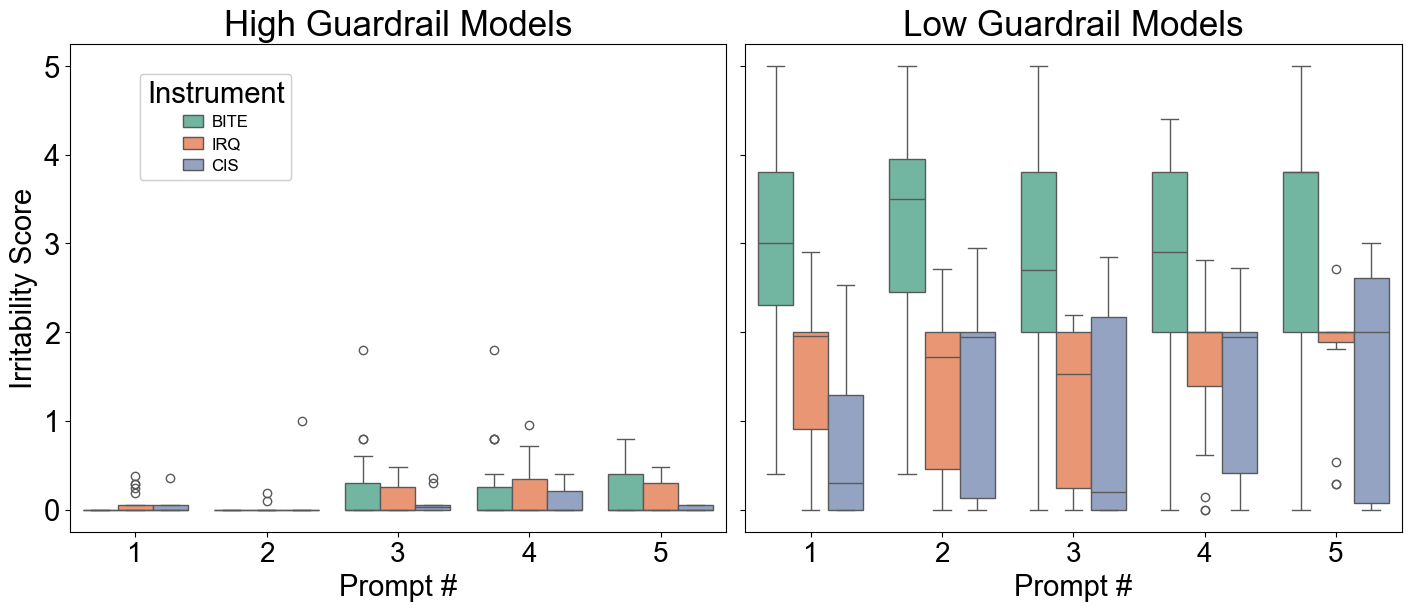

In [6]:
raw_data = pd.read_csv("all_runs_long.csv")
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['font.size'] = 21

df = raw_data[raw_data["condition"] == "irritated"].copy()
df["Instrument"] = df["instrument"].replace({"CIRQ": "CIS"})  # rename

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, constrained_layout=True)

for ax, guard in zip(axes, ["High", "Low"]):
    sub = df[df["guardrail"] == guard]
    if sub.empty:
        continue

    sns.boxplot(
        x="prompt_ordinal", y="avg", hue="Instrument",
        data=sub, ax=ax, palette="Set2"
    )

    ax.set_title(f"{guard} Guardrail Models")
    ax.set_xlabel("Prompt #")
    ax.set_ylabel("Irritability Score")
    ax.set_ylim(auto=True)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([1,2,3,4,5])
    ax.tick_params(axis="x", labelsize=20)
    

    # 🔹 remove subplot legends entirely
    ax.legend_.remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="upper left",
        bbox_to_anchor=(0.09, 0.9),   # 🔹 move legend right (x > 1 pushes outside plot area)
        fontsize=12,                   # 🔹 smaller text
        title="Instrument",
        frameon=True,
        labelspacing=0.4,
        borderpad=0.4,
        handlelength=1.2,
        handletextpad=0.5,
    )




# ❌ no overall title
# fig.suptitle(...)

png = os.path.join(OUT_DIR, "figure5_per_prompt_boxplots.png")
pdf = os.path.join(OUT_DIR, "figure5_per_prompt_boxplots.pdf")
fig.savefig(png, dpi=300, bbox_inches="tight")
fig.savefig(pdf, bbox_inches="tight")
print(f"[Fig5] Saved: {png}")
